# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.signal

# Download data

In this section we will download the data and setup the paths.


In [2]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

--2024-02-21 16:16:18--  https://www.cs.cmu.edu/~deva/data/aerialseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92160128 (88M)
Saving to: ‘/content/aerialseq.npy’

/content/aerialseq. 100%[===================>]  87.89M  6.90MB/s    in 13s     

2024-02-21 16:16:31 (6.79 MB/s) - ‘/content/aerialseq.npy’ saved [92160128/92160128]

--2024-02-21 16:16:32--  https://www.cs.cmu.edu/~deva/data/antseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M)
Saving to: ‘/content/antseq.npy’

/content/antseq.npy 100%[===================>]  62.50M  7.05MB/s    in 9.0s    

2024-02-21 16:16:41 (6.92 MB/s) - ‘/content/antseq.npy’ saved [65536128/65536128]



# Q3: Affine Motion Subtraction

## Q3.1: Dominant Motion Estimation (15 points)

In [3]:
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage import affine_transform

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    p = np.zeros(6)

    # Step1: create meshgrid
    H, W = It.shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    # Step2: interpolators
    spline_It = RectBivariateSpline(np.arange(H), np.arange(W), It)
    spline_It1 = RectBivariateSpline(np.arange(H), np.arange(W), It1)

    for _ in range(num_iters):
        M = np.array([[1+p[0], p[1], p[2]], [p[3], 1+p[4], p[5]]])
        warped_It1 = affine_transform(It1, M[:2, :2], offset=M[:2, 2], output_shape=(H, W), order=1)

        It1_x = scipy.signal.convolve2d(warped_It1, np.array([[-1, 0, 1]]), mode='same')
        It1_y = scipy.signal.convolve2d(warped_It1, np.array([[-1], [0], [1]]), mode='same')

        # A matrix and p1 to p6
        A = np.zeros((H*W, 6))
        A[:, 0] = X_flat * It1_x.ravel()
        A[:, 1] = Y_flat * It1_x.ravel()
        A[:, 2] = It1_x.ravel()
        A[:, 3] = X_flat * It1_y.ravel()
        A[:, 4] = Y_flat * It1_y.ravel()
        A[:, 5] = It1_y.ravel()

        # b
        b = spline_It.ev(Y, X).ravel() - warped_It1.ravel()

        delta_p, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        p += delta_p

        if np.linalg.norm(delta_p) < threshold:
            break

    M = np.array([[1+p[0], p[1], p[2]], [p[3], 1+p[4], p[5]]])

    # ===== End of code =====
    return M


## Debug Q3.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

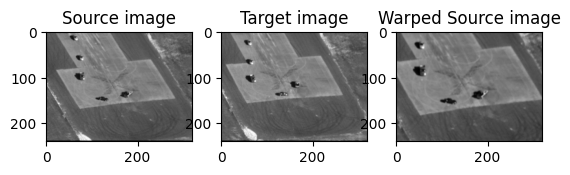

In [4]:
import cv2

num_iters = 100
threshold = 0.01
seq = np.load("/content/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = LucasKanadeAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

# Q3.2: Moving Object Detection (10 points)

In [5]:
import numpy as np
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.ndimage import affine_transform
import scipy.ndimage
import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param num_iters : (int), number of iterations for running the optimization
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: mask    : (H, W), the mask of the moved object
    """
    mask = np.ones(It.shape, dtype=bool)

    # ===== your code here! =====
    # M = LucasKanadeAffine(It, It1, threshold, num_iters)
    # M_cv2 = M[:2, :]
    # transformed_It = cv2.warpAffine(It, M_cv2, (It.shape[1], It.shape[0]))

    # difference = It1 - transformed_It
    # high_difference_idx = np.abs(difference) > tolerance

    # mask[high_difference_idx] = True

    # mask = binary_erosion(mask, structure=np.ones((2, 1)), iterations=1)
    # mask = binary_dilation(mask, iterations=1)

    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
    diff_image = np.abs(warped_It - It1)
    mask = diff_image > tolerance
    mask = binary_erosion(mask, structure=np.ones((2, 1)))
    mask = binary_dilation(mask, iterations = 1)

    # ===== End of code =====

    return mask


## Q3.3: Tracking with affine motion (10 points)

In [6]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:,:,0]
    masks =[]

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i-1]
        It1 = seq[:, :, i]

        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

## Q3.3 (a) - Track Ant Sequence

In [7]:
seq = np.load("/content/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [08:47<00:00,  4.25s/it]


Ant Sequence takes 527.604228 seconds


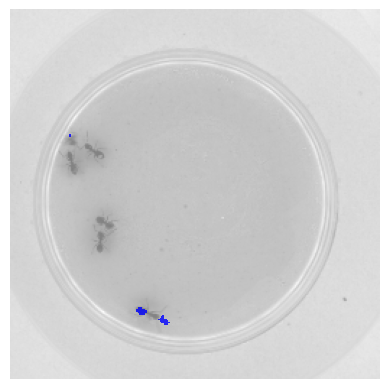

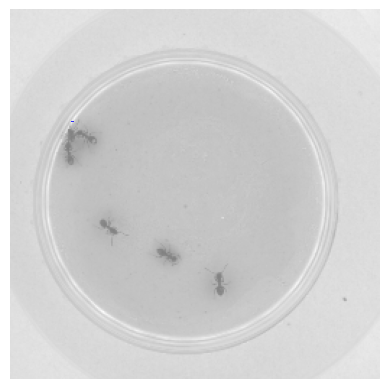

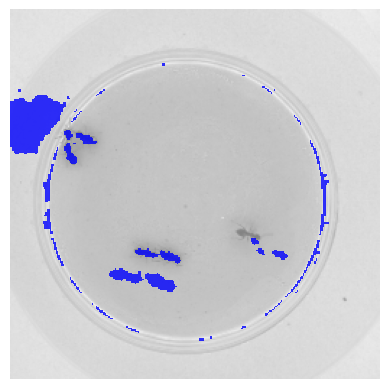

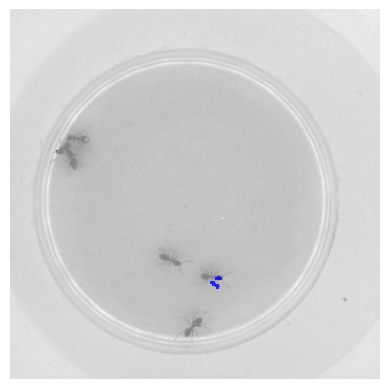

In [ ]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


### Q3.3 (b) - Track Aerial Sequence

In [ ]:
seq = np.load("/content/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 0.01
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [23:57<00:00,  9.65s/it]


Ant Sequence takes 1437.214954 seconds


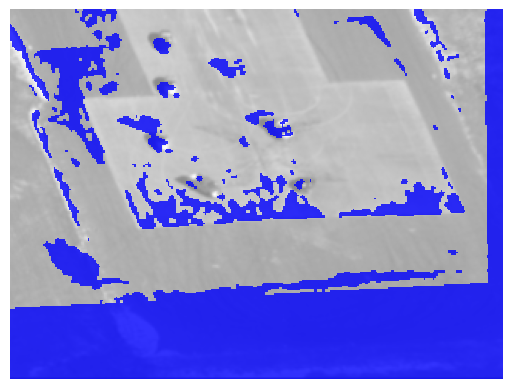

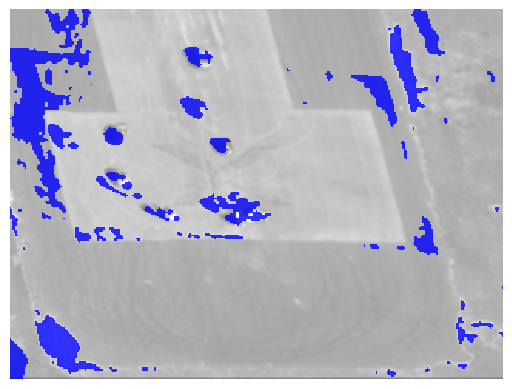

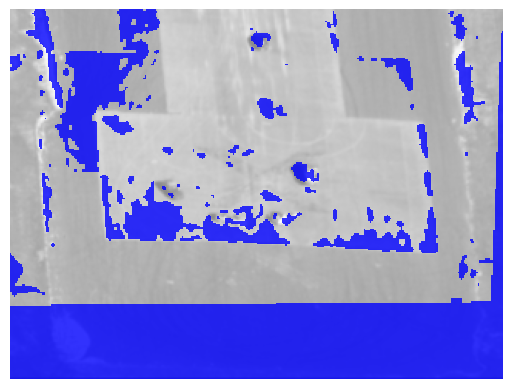

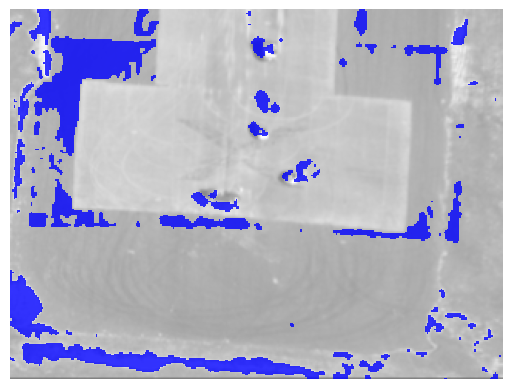

In [ ]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')